In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yaml
import torch
import json
import random
from pathlib import Path
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageFilter, ImageEnhance
import requests
from io import BytesIO
import chromadb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import warnings

warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✅ Libraries imported")

/home/roshan/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/roshan/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries imported


In [2]:
# Setup paths and load config
import os
os.environ["ANONYMIZED_TELEMETRY"] = "False"

ROOT = Path("..").resolve()
CONFIG_PATH = ROOT / "configs" / "config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

VDB_DIR = ROOT / "outputs" / "vector_db"
DATA_PROCESSED = ROOT / config.get("data", {}).get("processed_path", "Data/processed/")
OUTPUTS_DIR = ROOT / "outputs"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"📁 Root: {ROOT}")
print(f"🖥️  Device: {DEVICE}")

📁 Root: /home/roshan/Aria/mlops
🖥️  Device: cuda


In [3]:
# Load models and ChromaDB
TEXT_MODEL_NAME = config.get("feature_engineering", {}).get("text", {}).get("model_name", "paraphrase-multilingual-MiniLM-L12-v2")
IMAGE_MODEL_NAME = config.get("feature_engineering", {}).get("image", {}).get("model_name", "openai/clip-vit-base-patch32")

print("⏳ Loading models...")
text_model = SentenceTransformer(TEXT_MODEL_NAME, device=DEVICE)
clip_model = CLIPModel.from_pretrained(IMAGE_MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(IMAGE_MODEL_NAME)
clip_model.eval()

print("⏳ Connecting to ChromaDB...")
chroma_client = chromadb.PersistentClient(path=str(VDB_DIR))
col_text = chroma_client.get_collection("products_text")
col_image = chroma_client.get_collection("products_image")

print(f"✅ Text collection: {col_text.count()} embeddings")
print(f"✅ Image collection: {col_image.count()} embeddings")

⏳ Loading models...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 8738.13it/s]


⏳ Connecting to ChromaDB...
✅ Text collection: 1022296 embeddings
✅ Image collection: 9982 embeddings


In [31]:
# Noise generation functions

def add_text_noise(text: str, noise_level: float = 0.08) -> str:
    """Add character-level noise to Persian text."""
    if not text or len(text) < 3:
        return text
    
    chars = list(text)
    n_changes = max(1, int(len(chars) * noise_level))
    
    for _ in range(n_changes):
        pos = random.randint(0, len(chars) - 1)
        operation = random.choice(['swap', 'delete', 'duplicate'])
        
        if operation == 'swap' and pos < len(chars) - 1:
            chars[pos], chars[pos + 1] = chars[pos + 1], chars[pos]
        elif operation == 'delete' and len(chars) > 3:
            chars.pop(pos)
        elif operation == 'duplicate':
            chars.insert(pos, chars[pos])
    
    return ''.join(chars)

def add_image_noise(image: Image.Image) -> Image.Image:
    # Strong blur
    image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(2.5, 3)))

    # Brutal brightness
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.3, 1.2))

    # Strong contrast
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.4))

    # Large rotation + cropping artifacts
    angle = random.uniform(-20, 20)
    image = image.rotate(angle, fillcolor="white", expand=True)

    # Heavy color distortion
    image = ImageEnhance.Color(image).enhance(random.uniform(0.6, 1.5))

    return image



print("✅ Noise functions defined")

✅ Noise functions defined


In [39]:
# Create test dataset
TEST_SIZE = 300  # Number of test queries

print(f"⏳ Creating test dataset with {TEST_SIZE} samples...")

# Get all products that have both text and image embeddings
image_ids = set(col_image.get(include=[])["ids"])
text_data = col_text.get(include=["documents", "metadatas"], limit=col_text.count())

# Filter products that have both modalities
available_products = []
for i, pid in enumerate(text_data["ids"]):
    if pid in image_ids:
        available_products.append({
            "product_id": pid,
            "text": text_data["documents"][i],
            "metadata": text_data["metadatas"][i]
        })

print(f"✅ Found {len(available_products)} products with both text and image")

# Sample test set (stratified by category if possible)
if len(available_products) > TEST_SIZE:
    test_products = random.sample(available_products, TEST_SIZE)
else:
    test_products = available_products

print(f"✅ Sampled {len(test_products)} test products")

⏳ Creating test dataset with 300 samples...
✅ Found 9982 products with both text and image
✅ Sampled 300 test products


⏳ Generating noisy queries...
   Progress: 20 queries generated
   Progress: 40 queries generated
   Progress: 60 queries generated
   Progress: 80 queries generated
   Progress: 100 queries generated
   Progress: 120 queries generated
   Progress: 140 queries generated
   Progress: 160 queries generated
   Progress: 180 queries generated
   Progress: 200 queries generated
   Progress: 220 queries generated
   Progress: 240 queries generated
   Progress: 260 queries generated
   Progress: 280 queries generated
   Progress: 300 queries generated

✅ Test dataset created: 300 queries

📋 Sample query:
   Original text: میز تلویزیون کیا MKM65 | دسته: میز تلویزیون
   Noisy text: میز تلویزیون کیا MKM56 | دسته: میز تلویینو
   Ground truth: ogxcvh
🖼️  Sample Images: Original vs Noisy


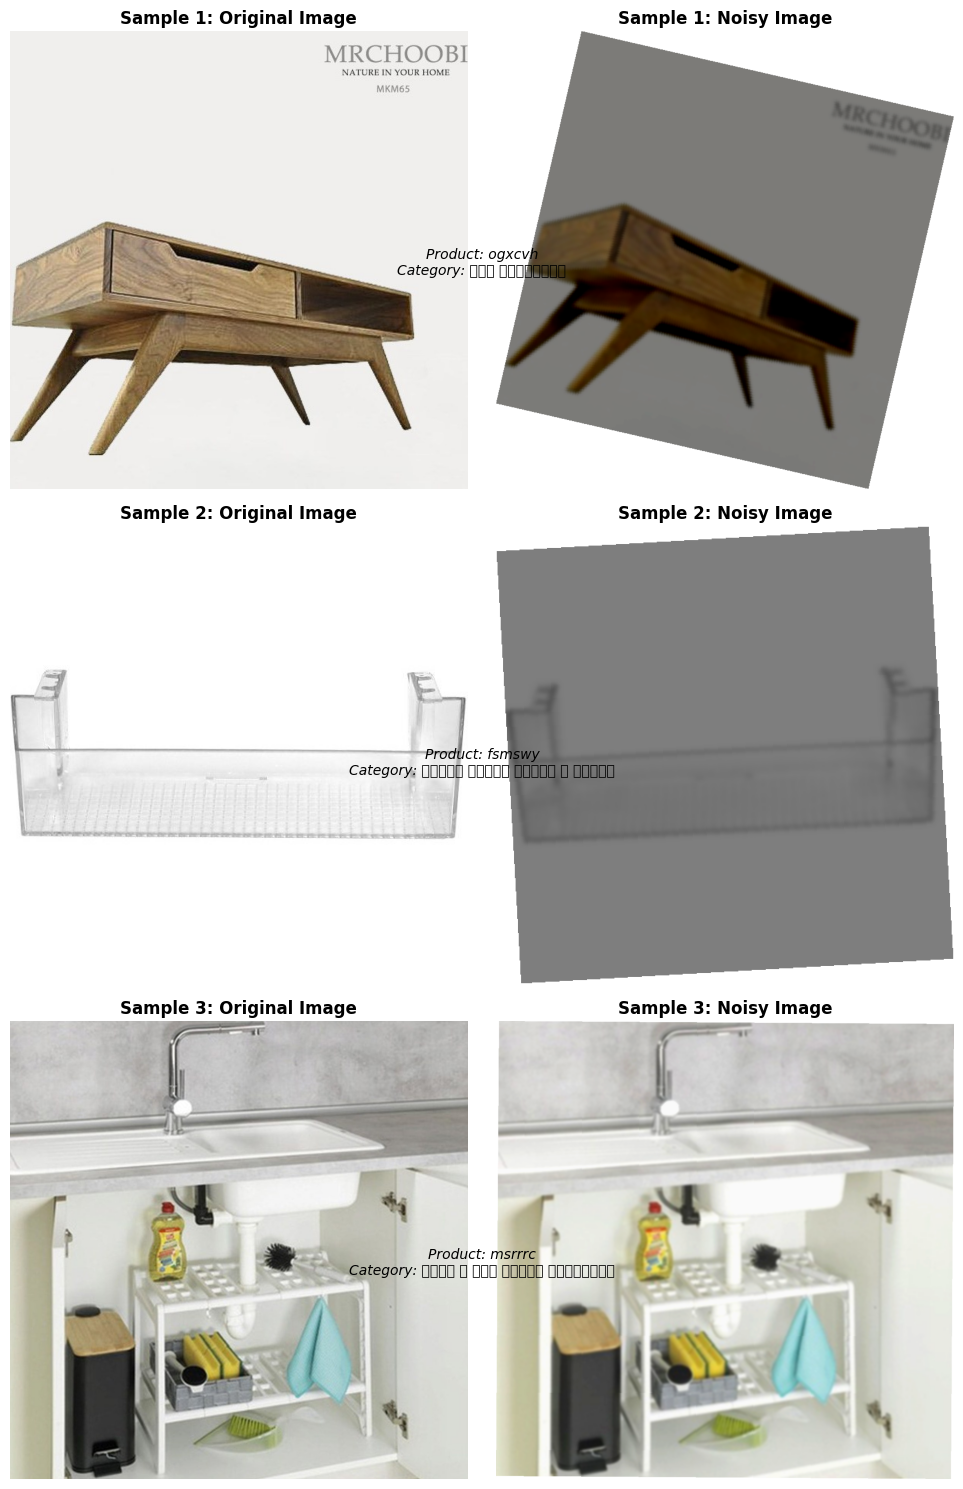


✅ Visual comparison complete
   Noise applied: blur, brightness, contrast, rotation, color saturation


In [40]:
# Generate noisy queries
print("⏳ Generating noisy queries...")

test_dataset = []

for item in test_products:
    # Get image
    try:
        img_data = col_image.get(ids=[item["product_id"]], include=["metadatas"])
        if not img_data["ids"]:
            continue
        
        img_url = img_data["metadatas"][0].get("image_url")
        response = requests.get(img_url, timeout=10)
        original_image = Image.open(BytesIO(response.content)).convert("RGB")
        
        # Extract only product name (before " | دسته:" or similar separators)
        original_text = item["text"]
        if " | " in original_text:
            product_name_only = original_text
        else:
            product_name_only = original_text.strip()
        
        # Create noisy version of product name only
        noisy_text = add_text_noise(product_name_only)
        noisy_image = add_image_noise(original_image.copy())
        
        test_dataset.append({
            "query_id": f"test_{len(test_dataset):03d}",
            "product_id": item["product_id"],
            "original_text": product_name_only,  # Store only product name
            "noisy_text": noisy_text,
            "original_image": original_image,
            "noisy_image": noisy_image,
            "relevant_ids": [item["product_id"]],  # Ground truth
            "metadata": item["metadata"]
        })
        
        if len(test_dataset) % 20 == 0:
            print(f"   Progress: {len(test_dataset)} queries generated")
    
    except Exception as e:
        continue

print(f"\n✅ Test dataset created: {len(test_dataset)} queries")
print(f"\n📋 Sample query:")
print(f"   Original text: {test_dataset[0]['original_text'][:80]}")
print(f"   Noisy text: {test_dataset[0]['noisy_text'][:80]}")
print(f"   Ground truth: {test_dataset[0]['product_id']}")
# Visualize sample images and their noisy versions
print("🖼️  Sample Images: Original vs Noisy")
print("=" * 70)

# Show first 3 test samples
num_samples = min(3, len(test_dataset))

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    item = test_dataset[i]
    
    # Original image
    axes[i, 0].imshow(item["original_image"])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Sample {i+1}: Original Image", fontsize=12, fontweight='bold')
    
    # Noisy image
    axes[i, 1].imshow(item["noisy_image"])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Sample {i+1}: Noisy Image", fontsize=12, fontweight='bold')
    
    # Add product info as text below images
    product_info = f"Product: {item['product_id']}\nCategory: {item['metadata'].get('category_title', 'N/A')}"
    fig.text(0.5, (num_samples - i - 0.5) / num_samples - 0.02, product_info, 
             ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

print("\n✅ Visual comparison complete")
print(f"   Noise applied: blur, brightness, contrast, rotation, color saturation")

In [22]:
# Retrieval functions

def text_retrieval(query: str, k: int = 10) -> List[str]:
    """Retrieve product IDs using text query."""
    query_embedding = text_model.encode([query], normalize_embeddings=True)
    results = col_text.query(
        query_embeddings=query_embedding.tolist(),
        n_results=k,
        include=[]
    )
    return results["ids"][0]


def image_retrieval(image: Image.Image, k: int = 10) -> List[str]:
    """Retrieve product IDs using image query."""
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    
    image_embedding = image_features / image_features.norm(dim=-1, keepdim=True)
    image_embedding = image_embedding.cpu().numpy().flatten()
    
    results = col_image.query(
        query_embeddings=[image_embedding.tolist()],
        n_results=k,
        include=[]
    )
    return results["ids"][0]


def multimodal_retrieval(text_query: str, image: Image.Image, k: int = 10, alpha: float = 0.5) -> List[str]:
    """Retrieve product IDs using both text and image with weighted fusion."""
    # Get separate results
    text_results = text_retrieval(text_query, k=k*2)
    image_results = image_retrieval(image, k=k*2)
    
    # Score fusion
    scores = {}
    for rank, pid in enumerate(text_results):
        scores[pid] = alpha * (1.0 / (rank + 1))
    
    for rank, pid in enumerate(image_results):
        if pid in scores:
            scores[pid] += (1 - alpha) * (1.0 / (rank + 1))
        else:
            scores[pid] = (1 - alpha) * (1.0 / (rank + 1))
    
    # Sort and return top-k
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [pid for pid, _ in ranked[:k]]


print("✅ Retrieval functions ready")

✅ Retrieval functions ready


In [9]:
# Evaluation metrics

def mean_reciprocal_rank(retrieved_ids: List[str], relevant_ids: List[str]) -> float:
    """
    Calculate MRR (Mean Reciprocal Rank).
    Returns 1/rank of first relevant item, 0 if none found.
    """
    for rank, pid in enumerate(retrieved_ids, 1):
        if pid in relevant_ids:
            return 1.0 / rank
    return 0.0


def precision_at_k(retrieved_ids: List[str], relevant_ids: List[str], k: int = 10) -> float:
    """
    Calculate Precision@k.
    Returns fraction of relevant items in top-k.
    """
    retrieved_k = retrieved_ids[:k]
    relevant_count = sum(1 for pid in retrieved_k if pid in relevant_ids)
    return relevant_count / k if k > 0 else 0.0


def category_hit_rate(retrieved_ids: List[str], query_category: str, start_rank: int = 2, end_rank: int = 10) -> float:
    """
    Calculate category hit rate - whether any retrieved product (excluding rank 1) 
    belongs to the same category as the query.
    
    Args:
        retrieved_ids: List of retrieved product IDs
        query_category: Category of the query product
        start_rank: Start checking from this rank (default 2, to skip exact match)
        end_rank: End checking at this rank (default 10)
    
    Returns:
        1.0 if at least one product in range matches category, 0.0 otherwise
    """
    if not query_category or query_category == "N/A":
        return 0.0
    
    # Check products from start_rank to end_rank (1-indexed, so adjust)
    products_to_check = retrieved_ids[start_rank-1:end_rank]
    
    for pid in products_to_check:
        try:
            # Fetch category from ChromaDB
            result = col_text.get(ids=[pid], include=["metadatas"])
            if result["ids"]:
                retrieved_category = result["metadatas"][0].get("category_title", "")
                if retrieved_category == query_category:
                    return 1.0
        except:
            continue
    
    return 0.0


def evaluate_retrieval(test_data: List[Dict], retrieval_fn, k: int = 10, compute_category_hit: bool = False) -> Dict:
    """
    Evaluate retrieval function on test dataset.
    Returns average MRR, Precision@k, and optionally category hit rate.
    """
    mrr_scores = []
    precision_scores = []
    category_hits = []
    
    for item in test_data:
        retrieved = retrieval_fn(item, k=k)
        
        mrr = mean_reciprocal_rank(retrieved, item["relevant_ids"])
        precision = precision_at_k(retrieved, item["relevant_ids"], k=k)
        
        mrr_scores.append(mrr)
        precision_scores.append(precision)
        
        # Compute category hit rate for image retrieval
        if compute_category_hit:
            query_category = item["metadata"].get("category_title", "")
            cat_hit = category_hit_rate(retrieved, query_category, start_rank=2, end_rank=10)
            category_hits.append(cat_hit)
    
    results = {
        "MRR": np.mean(mrr_scores),
        "Precision@k": np.mean(precision_scores),
        "num_queries": len(test_data)
    }
    
    if compute_category_hit:
        results["Category_Hit_Rate@2-10"] = np.mean(category_hits)
    
    return results


print("✅ Metrics defined")

✅ Metrics defined


In [10]:
# Define Optuna objective function

K_VALUE = 10  # Fixed k for retrieval

def objective(trial):
    """Optuna objective: maximize Category Hit Rate@2-10 for multimodal retrieval."""
    # Suggest alpha value
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    
    # Define retrieval function with this alpha
    def retrieval_fn(item, k=K_VALUE):
        return multimodal_retrieval(
            text_query=item["noisy_text"],
            image=item["noisy_image"],
            k=k,
            alpha=alpha
        )
    
    # Evaluate on test dataset with category hit rate
    results = evaluate_retrieval(test_dataset, retrieval_fn, k=K_VALUE, compute_category_hit=True)
    
    # Objective: maximize Category Hit Rate@2-10 (same as image search evaluation)
    score = results["Category_Hit_Rate@2-10"]
    
    return score


print("✅ Objective function defined")
print(f"📊 Search space: alpha ∈ [0.0, 1.0]")
print(f"🎯 Objective: Maximize Category Hit Rate@2-10")

✅ Objective function defined
📊 Search space: alpha ∈ [0.0, 1.0]
🎯 Objective: Maximize Category Hit Rate@2-10


In [37]:
# Run Optuna optimization
N_TRIALS = 20  # Number of optimization trials

print(f"⏳ Starting Optuna optimization ({N_TRIALS} trials)...")
print("=" * 70)

# Create study
study = optuna.create_study(
    direction="maximize",
    study_name="multimodal_alpha_tuning",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
)

# Optimize
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "=" * 70)
print("✅ Optimization complete!")
print("=" * 70)
print(f"\n🏆 Best trial:")
print(f"   Trial number: {study.best_trial.number}")
print(f"   Best score: {study.best_trial.value:.4f}")
print(f"   Best alpha: {study.best_params['alpha']:.4f}")

[I 2026-01-05 20:31:44,713] A new study created in memory with name: multimodal_alpha_tuning


⏳ Starting Optuna optimization (20 trials)...


Best trial: 0. Best value: 0.98:   5%|▌         | 1/20 [00:08<02:41,  8.51s/it]

[I 2026-01-05 20:31:53,222] Trial 0 finished with value: 0.98 and parameters: {'alpha': 0.3745401188473625}. Best is trial 0 with value: 0.98.


Best trial: 0. Best value: 0.98:  10%|█         | 2/20 [00:15<02:19,  7.73s/it]

[I 2026-01-05 20:32:00,407] Trial 1 finished with value: 0.98 and parameters: {'alpha': 0.9507143064099162}. Best is trial 0 with value: 0.98.


Best trial: 2. Best value: 0.99:  15%|█▌        | 3/20 [00:25<02:24,  8.51s/it]

[I 2026-01-05 20:32:09,838] Trial 2 finished with value: 0.99 and parameters: {'alpha': 0.7319939418114051}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  20%|██        | 4/20 [00:35<02:27,  9.20s/it]

[I 2026-01-05 20:32:20,103] Trial 3 finished with value: 0.99 and parameters: {'alpha': 0.5986584841970366}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  25%|██▌       | 5/20 [00:45<02:20,  9.40s/it]

[I 2026-01-05 20:32:29,857] Trial 4 finished with value: 0.88 and parameters: {'alpha': 0.15601864044243652}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  30%|███       | 6/20 [00:52<02:02,  8.75s/it]

[I 2026-01-05 20:32:37,351] Trial 5 finished with value: 0.88 and parameters: {'alpha': 0.15599452033620265}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  35%|███▌      | 7/20 [01:01<01:52,  8.68s/it]

[I 2026-01-05 20:32:45,888] Trial 6 finished with value: 0.63 and parameters: {'alpha': 0.05808361216819946}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  40%|████      | 8/20 [01:09<01:41,  8.42s/it]

[I 2026-01-05 20:32:53,741] Trial 7 finished with value: 0.99 and parameters: {'alpha': 0.8661761457749352}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  45%|████▌     | 9/20 [01:18<01:35,  8.70s/it]

[I 2026-01-05 20:33:03,047] Trial 8 finished with value: 0.99 and parameters: {'alpha': 0.6011150117432088}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  50%|█████     | 10/20 [01:25<01:21,  8.19s/it]

[I 2026-01-05 20:33:10,112] Trial 9 finished with value: 0.99 and parameters: {'alpha': 0.7080725777960455}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  55%|█████▌    | 11/20 [01:31<01:08,  7.61s/it]

[I 2026-01-05 20:33:16,390] Trial 10 finished with value: 0.98 and parameters: {'alpha': 0.3207617602446551}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  60%|██████    | 12/20 [01:38<00:58,  7.34s/it]

[I 2026-01-05 20:33:23,119] Trial 11 finished with value: 0.99 and parameters: {'alpha': 0.722202633806083}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  65%|██████▌   | 13/20 [01:47<00:54,  7.75s/it]

[I 2026-01-05 20:33:31,813] Trial 12 finished with value: 0.98 and parameters: {'alpha': 0.5017963590007539}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  70%|███████   | 14/20 [01:56<00:48,  8.16s/it]

[I 2026-01-05 20:33:40,907] Trial 13 finished with value: 0.99 and parameters: {'alpha': 0.7870489042829878}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  75%|███████▌  | 15/20 [02:06<00:44,  8.95s/it]

[I 2026-01-05 20:33:51,685] Trial 14 finished with value: 0.99 and parameters: {'alpha': 0.5858240085083514}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  80%|████████  | 16/20 [02:13<00:33,  8.28s/it]

[I 2026-01-05 20:33:58,433] Trial 15 finished with value: 0.98 and parameters: {'alpha': 0.3843807771412294}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  85%|████████▌ | 17/20 [02:20<00:23,  7.86s/it]

[I 2026-01-05 20:34:05,289] Trial 16 finished with value: 0.99 and parameters: {'alpha': 0.616226526590371}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  90%|█████████ | 18/20 [02:27<00:15,  7.55s/it]

[I 2026-01-05 20:34:12,130] Trial 17 finished with value: 0.98 and parameters: {'alpha': 0.9655515602276162}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99:  95%|█████████▌| 19/20 [02:33<00:07,  7.18s/it]

[I 2026-01-05 20:34:18,442] Trial 18 finished with value: 0.98 and parameters: {'alpha': 0.4946443014220542}. Best is trial 2 with value: 0.99.


Best trial: 2. Best value: 0.99: 100%|██████████| 20/20 [02:43<00:00,  8.19s/it]

[I 2026-01-05 20:34:28,577] Trial 19 finished with value: 0.99 and parameters: {'alpha': 0.829996261135134}. Best is trial 2 with value: 0.99.

✅ Optimization complete!

🏆 Best trial:
   Trial number: 2
   Best score: 0.9900
   Best alpha: 0.7320


In [41]:
# Evaluate all three modalities
best_alpha = study.best_params["alpha"]

print("⏳ Evaluating all modalities with optimized parameters...")
print("=" * 70)

# 1. Text-only retrieval
def text_only_fn(item, k=K_VALUE):
    return text_retrieval(item["noisy_text"], k=k)

text_results = evaluate_retrieval(test_dataset, text_only_fn, k=K_VALUE)
print(f"\n📝 Text-Only Retrieval:")
print(f"   MRR: {text_results['MRR']:.4f}")
print(f"   Precision@{K_VALUE}: {text_results['Precision@k']:.4f}")

# 2. Image-only retrieval
def image_only_fn(item, k=K_VALUE):
    return image_retrieval(item["noisy_image"], k=k)

image_results = evaluate_retrieval(test_dataset, image_only_fn, k=K_VALUE, compute_category_hit=True)
print(f"\n🖼️  Image-Only Retrieval:")
print(f"   MRR: {image_results['MRR']:.4f}")
print(f"   Precision@{K_VALUE}: {image_results['Precision@k']:.4f}")
print(f"   Category Hit Rate@2-10: {image_results['Category_Hit_Rate@2-10']:.4f}")
print(f"   → {image_results['Category_Hit_Rate@2-10']*100:.1f}% queries found same-category product in ranks 2-10")

# 3. Multimodal retrieval with best alpha
def multimodal_fn(item, k=K_VALUE):
    return multimodal_retrieval(
        item["noisy_text"],
        item["noisy_image"],
        k=k,
        alpha=best_alpha
    )

multimodal_results = evaluate_retrieval(test_dataset, multimodal_fn, k=K_VALUE, compute_category_hit=True)
print(f"\n🔀 Multimodal Retrieval (alpha={best_alpha:.4f}):")
print(f"   MRR: {multimodal_results['MRR']:.4f}")
print(f"   Precision@{K_VALUE}: {multimodal_results['Precision@k']:.4f}")
print(f"   Category Hit Rate@2-10: {multimodal_results['Category_Hit_Rate@2-10']:.4f}")
print(f"   → {multimodal_results['Category_Hit_Rate@2-10']*100:.1f}% queries found same-category product in ranks 2-10")

print("\n" + "=" * 70)

# Show sample failures for text-only retrieval
print("\n\n🔍 Sample Text-Only Retrieval Failures:")
print("=" * 70)

failure_count = 0
for i, item in enumerate(test_dataset):
    if failure_count >= 5:  # Show 5 examples
        break
    
    text_ret = text_retrieval(item["noisy_text"], k=10)
    
    # Check if ground truth is not in top-3
    if item['product_id'] not in text_ret[:3]:
        failure_count += 1
        
        # Get rank
        if item['product_id'] in text_ret:
            rank = text_ret.index(item['product_id']) + 1
            rank_str = f"#{rank}"
        else:
            rank_str = "Not in top-10"
        
        print(f"\n{'─'*70}")
        print(f"Failure #{failure_count}")
        print(f"{'─'*70}")
        print(f"Ground Truth: {item['product_id']}")
        print(f"Category: {item['metadata'].get('category_title', 'N/A')}")
        print(f"Brand: {item['metadata'].get('brand_title', 'N/A')}")
        print(f"\n📝 Original text: {item['original_text'][:100]}...")
        print(f"🔄 Noisy text:    {item['noisy_text'][:100]}...")
        print(f"\n❌ Ground truth ranked: {rank_str}")
        print(f"\n✅ Top-3 retrieved instead:")
        
        # Fetch and show what was retrieved
        for j, ret_id in enumerate(text_ret[:3], 1):
            ret_data = col_text.get(ids=[ret_id], include=["documents", "metadatas"])
            if ret_data["ids"]:
                ret_text = ret_data["documents"][0][:80]
                ret_cat = ret_data["metadatas"][0].get("category_title", "N/A")
                print(f"   {j}. {ret_id} - {ret_cat}")
                print(f"      Text: {ret_text}...")

print("\n" + "=" * 70)

⏳ Evaluating all modalities with optimized parameters...

📝 Text-Only Retrieval:
   MRR: 0.7411
   Precision@10: 0.0823



🖼️  Image-Only Retrieval:
   MRR: 0.6707
   Precision@10: 0.0773
   Category Hit Rate@2-10: 0.6033
   → 60.3% queries found same-category product in ranks 2-10

🔀 Multimodal Retrieval (alpha=0.7320):
   MRR: 0.7880
   Precision@10: 0.0947
   Category Hit Rate@2-10: 0.9800
   → 98.0% queries found same-category product in ranks 2-10



🔍 Sample Text-Only Retrieval Failures:

──────────────────────────────────────────────────────────────────────
Failure #1
──────────────────────────────────────────────────────────────────────
Ground Truth: fprftg
Category: میز جلو مبلی و عسلی
Brand: ایکیا / Ikea

📝 Original text: میز عسلی 55 سانتی‌ متر ایکیا LACK | برند: ایکیا / Ikea | دسته: میز جلو مبلی و عسلی...
🔄 Noisy text:    یمزع سلی 55 سانتی‌متر ایکیا LACK | بنرد: ایکیا / Ike | دسته: میز جلو مبلی و عسلی...

❌ Ground truth ranked: Not in top-10

✅ Top-3 retrieved instead:
   1. uzalxq - لوازم یدکی آشپزخانه
      Text: همزن 54 سانتی استیل ویکتور | دسته: لوازم یدکی آشپزخانه...
   2. jbmheo - گیاه ار

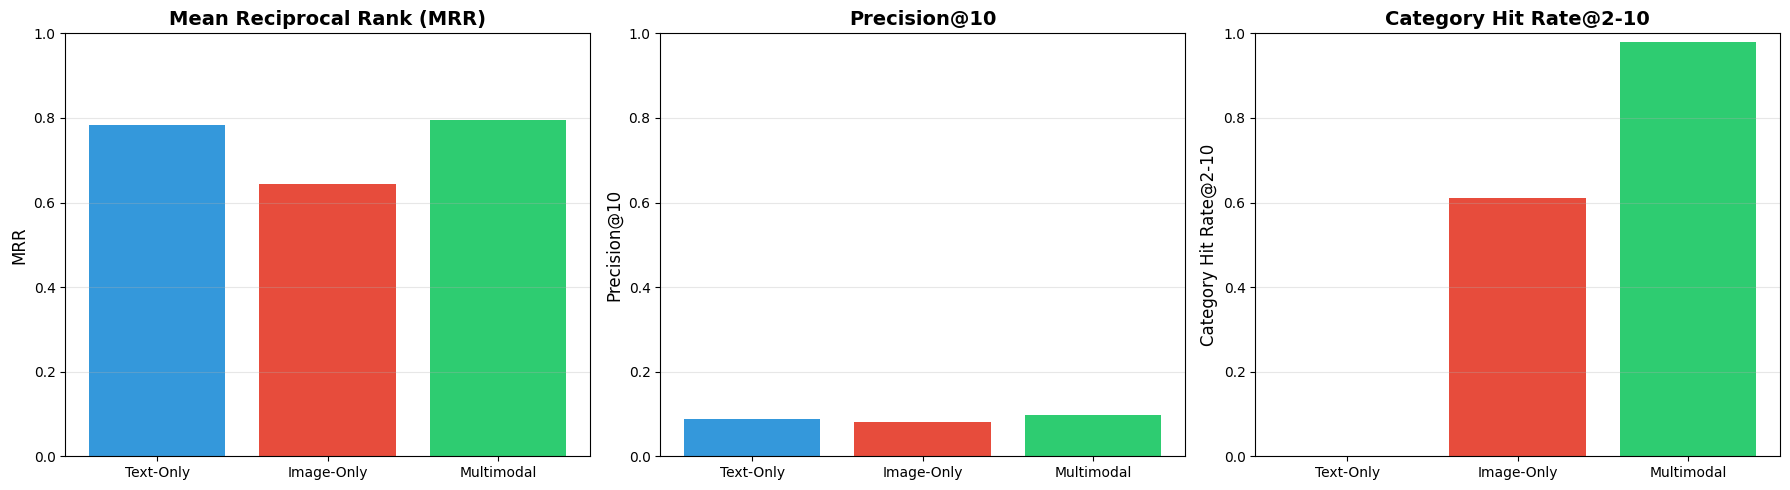


📊 Performance Comparison Table:
  Modality      MRR  Precision@10  Category Hit Rate@2-10
 Text-Only 0.783778         0.088                    0.00
Image-Only 0.644917         0.081                    0.61
Multimodal 0.795333         0.098                    0.98


In [34]:
# Comparison visualization
comparison_data = {
    "Modality": ["Text-Only", "Image-Only", "Multimodal"],
    "MRR": [text_results["MRR"], image_results["MRR"], multimodal_results["MRR"]],
    f"Precision@{K_VALUE}": [
        text_results["Precision@k"],
        image_results["Precision@k"],
        multimodal_results["Precision@k"]
    ],
    "Category Hit Rate@2-10": [
        0.0,  # Not computed for text-only
        image_results["Category_Hit_Rate@2-10"],
        multimodal_results["Category_Hit_Rate@2-10"]
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MRR comparison
axes[0].bar(df_comparison["Modality"], df_comparison["MRR"], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_ylabel("MRR", fontsize=12)
axes[0].set_title("Mean Reciprocal Rank (MRR)", fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].grid(axis='y', alpha=0.3)

# Precision comparison
axes[1].bar(df_comparison["Modality"], df_comparison[f"Precision@{K_VALUE}"], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel(f"Precision@{K_VALUE}", fontsize=12)
axes[1].set_title(f"Precision@{K_VALUE}", fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', alpha=0.3)

# Category Hit Rate comparison
axes[2].bar(df_comparison["Modality"], df_comparison["Category Hit Rate@2-10"], color=['#95a5a6', '#e74c3c', '#2ecc71'])
axes[2].set_ylabel("Category Hit Rate@2-10", fontsize=12)
axes[2].set_title("Category Hit Rate@2-10", fontsize=14, fontweight='bold')
axes[2].set_ylim(0, 1.0)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display table
print("\n📊 Performance Comparison Table:")
print(df_comparison.to_string(index=False))

In [43]:
# Category-level performance analysis
print("📊 Category-Level Performance Analysis")
print("=" * 70)

# Collect predictions and ground truth categories for all modalities
results_by_category = {}

for item in test_dataset:
    query_category = item["metadata"].get("category_title", "Unknown")
    
    if query_category not in results_by_category:
        results_by_category[query_category] = {
            "count": 0,
            "text_correct": 0,
            "image_correct": 0,
            "multimodal_correct": 0,
            "text_top3": 0,
            "image_top3": 0,
            "multimodal_top3": 0,
            "predicted_categories": {"text": [], "image": [], "multimodal": []}
        }
    
    results_by_category[query_category]["count"] += 1
    
    # Get predictions
    text_ret = text_retrieval(item["noisy_text"], k=10)
    image_ret = image_retrieval(item["noisy_image"], k=10)
    multi_ret = multimodal_retrieval(item["noisy_text"], item["noisy_image"], k=10, alpha=best_alpha)
    
    ground_truth_id = item["product_id"]
    
    # Check if correct (rank 1)
    if text_ret[0] == ground_truth_id:
        results_by_category[query_category]["text_correct"] += 1
    if image_ret[0] == ground_truth_id:
        results_by_category[query_category]["image_correct"] += 1
    if multi_ret[0] == ground_truth_id:
        results_by_category[query_category]["multimodal_correct"] += 1
    
    # Check if in top-3
    if ground_truth_id in text_ret[:3]:
        results_by_category[query_category]["text_top3"] += 1
    if ground_truth_id in image_ret[:3]:
        results_by_category[query_category]["image_top3"] += 1
    if ground_truth_id in multi_ret[:3]:
        results_by_category[query_category]["multimodal_top3"] += 1
    
    # Get predicted categories (for confusion analysis)
    for ret_id in text_ret[:3]:
        ret_cat = col_text.get(ids=[ret_id], include=["metadatas"])
        if ret_cat["ids"]:
            pred_cat = ret_cat["metadatas"][0].get("category_title", "Unknown")
            results_by_category[query_category]["predicted_categories"]["text"].append(pred_cat)
    
    for ret_id in image_ret[:3]:
        ret_cat = col_text.get(ids=[ret_id], include=["metadatas"])
        if ret_cat["ids"]:
            pred_cat = ret_cat["metadatas"][0].get("category_title", "Unknown")
            results_by_category[query_category]["predicted_categories"]["image"].append(pred_cat)
    
    for ret_id in multi_ret[:3]:
        ret_cat = col_text.get(ids=[ret_id], include=["metadatas"])
        if ret_cat["ids"]:
            pred_cat = ret_cat["metadatas"][0].get("category_title", "Unknown")
            results_by_category[query_category]["predicted_categories"]["multimodal"].append(pred_cat)

# Create performance DataFrame
category_performance = []
for category, stats in results_by_category.items():
    if stats["count"] > 0:
        category_performance.append({
            "Category": category[:30] + "..." if len(category) > 30 else category,  # Truncate long names
            "Count": stats["count"],
            "Text Acc@1": stats["text_correct"] / stats["count"],
            "Image Acc@1": stats["image_correct"] / stats["count"],
            "Multi Acc@1": stats["multimodal_correct"] / stats["count"],
            "Text Acc@3": stats["text_top3"] / stats["count"],
            "Image Acc@3": stats["image_top3"] / stats["count"],
            "Multi Acc@3": stats["multimodal_top3"] / stats["count"]
        })

df_category = pd.DataFrame(category_performance)
df_category = df_category.sort_values("Count", ascending=False)

print(f"\n📋 Performance by Category (Top 10 by sample count):")
print(df_category.head(10).to_string(index=False))

print("\n" + "=" * 70)

📊 Category-Level Performance Analysis

📋 Performance by Category (Top 10 by sample count):
                 Category  Count  Text Acc@1  Image Acc@1  Multi Acc@1  Text Acc@3  Image Acc@3  Multi Acc@3
            تابلو و مجسمه     19    0.789474     0.947368     0.789474    0.789474     0.947368     0.947368
                      ماگ     11    0.818182     0.636364     0.818182    0.909091     0.636364     1.000000
            رومیزی و پرده      6    0.500000     0.666667     0.500000    0.500000     0.833333     0.666667
              انواع پارچه      6    0.333333     0.500000     0.333333    0.500000     0.833333     0.666667
      لوستر و چراغ تزئینی      6    0.833333     0.666667     0.833333    0.833333     0.666667     1.000000
روتختی، لحاف و سرویس خواب      6    0.666667     0.500000     0.666667    0.833333     0.666667     1.000000
        گلدان و گل مصنوعی      6    0.500000     0.666667     0.500000    0.500000     0.833333     0.666667
              کتری و قوری      5    0


📊 Category Performance Visualization


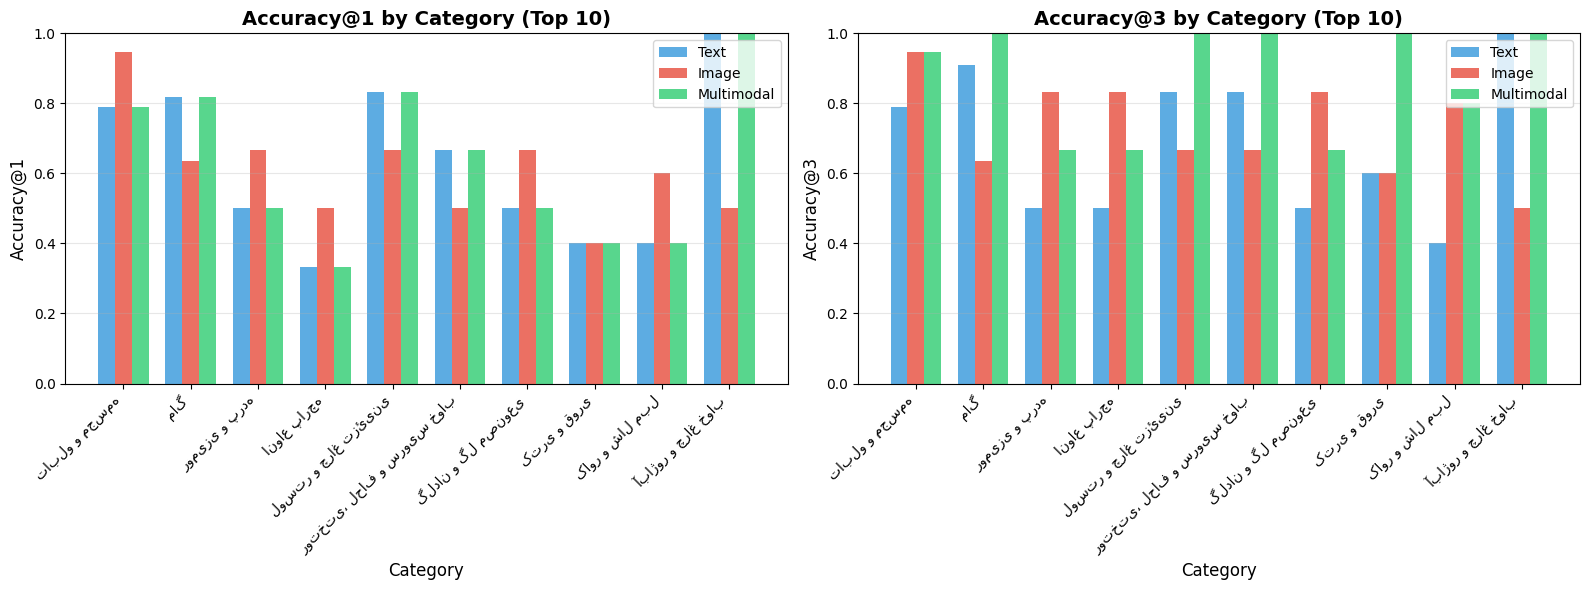

In [44]:
# Visualize category performance
print("\n📊 Category Performance Visualization")

# Select top 10 categories by count for visualization
top_categories = df_category.head(10).copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy@1 comparison
x = np.arange(len(top_categories))
width = 0.25

axes[0].bar(x - width, top_categories["Text Acc@1"], width, label='Text', color='#3498db', alpha=0.8)
axes[0].bar(x, top_categories["Image Acc@1"], width, label='Image', color='#e74c3c', alpha=0.8)
axes[0].bar(x + width, top_categories["Multi Acc@1"], width, label='Multimodal', color='#2ecc71', alpha=0.8)

axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Accuracy@1', fontsize=12)
axes[0].set_title('Accuracy@1 by Category (Top 10)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_categories["Category"], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1.0)

# Accuracy@3 comparison
axes[1].bar(x - width, top_categories["Text Acc@3"], width, label='Text', color='#3498db', alpha=0.8)
axes[1].bar(x, top_categories["Image Acc@3"], width, label='Image', color='#e74c3c', alpha=0.8)
axes[1].bar(x + width, top_categories["Multi Acc@3"], width, label='Multimodal', color='#2ecc71', alpha=0.8)

axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Accuracy@3', fontsize=12)
axes[1].set_title('Accuracy@3 by Category (Top 10)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_categories["Category"], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


🔬 Failure Mode Analysis


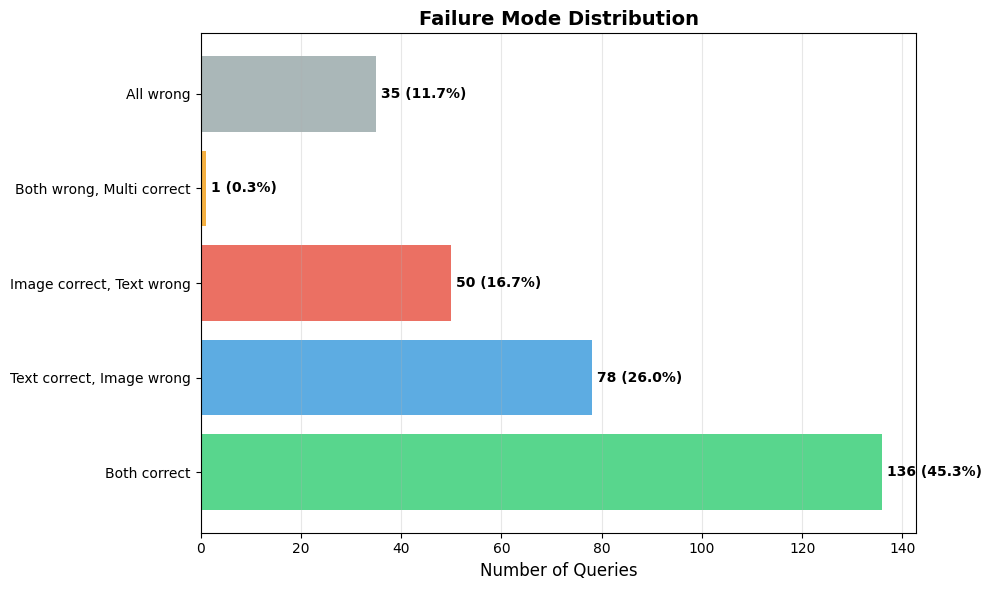


📊 Failure Mode Summary:
   Both correct: 136 (45.3%)
   Text correct, Image wrong: 78 (26.0%)
   Image correct, Text wrong: 50 (16.7%)
   Both wrong, Multi correct: 1 (0.3%)
   All wrong: 35 (11.7%)

💡 Multimodal improvement cases: 1
   → Cases where both text and image were wrong, but multimodal fusion got it right!
   → This demonstrates the value of combining modalities


In [48]:
# Failure mode analysis
print("\n🔬 Failure Mode Analysis")
print("=" * 70)

# Analyze when each modality fails vs succeeds
failure_analysis = {
    "Both correct": 0,
    "Text correct, Image wrong": 0,
    "Image correct, Text wrong": 0,
    "Both wrong, Multi correct": 0,
    "All wrong": 0
}

multimodal_improvement_cases = []

for item in test_dataset:
    text_ret = text_retrieval(item["noisy_text"], k=1)
    image_ret = image_retrieval(item["noisy_image"], k=1)
    multi_ret = multimodal_retrieval(item["noisy_text"], item["noisy_image"], k=1, alpha=best_alpha)
    
    ground_truth = item["product_id"]
    
    text_correct = (text_ret[0] == ground_truth)
    image_correct = (image_ret[0] == ground_truth)
    multi_correct = (multi_ret[0] == ground_truth)
    
    if text_correct and image_correct:
        failure_analysis["Both correct"] += 1
    elif text_correct and not image_correct:
        failure_analysis["Text correct, Image wrong"] += 1
    elif not text_correct and image_correct:
        failure_analysis["Image correct, Text wrong"] += 1
    elif not text_correct and not image_correct and multi_correct:
        failure_analysis["Both wrong, Multi correct"] += 1
        multimodal_improvement_cases.append(item)
    else:
        failure_analysis["All wrong"] += 1

# Visualize failure modes
fig, ax = plt.subplots(figsize=(10, 6))
modes = list(failure_analysis.keys())
counts = list(failure_analysis.values())
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#95a5a6']

bars = ax.barh(modes, counts, color=colors, alpha=0.8)
ax.set_xlabel('Number of Queries', fontsize=12)
ax.set_title('Failure Mode Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add count labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 1, i, f'{count} ({count/len(test_dataset)*100:.1f}%)', 
           va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Failure Mode Summary:")
for mode, count in failure_analysis.items():
    print(f"   {mode}: {count} ({count/len(test_dataset)*100:.1f}%)")

print(f"\n💡 Multimodal improvement cases: {len(multimodal_improvement_cases)}")
print(f"   → Cases where both text and image were wrong, but multimodal fusion got it right!")
print(f"   → This demonstrates the value of combining modalities")

In [47]:
# Category-specific success/failure patterns
print("\n🎯 Category-Specific Patterns")
print("=" * 70)

# Find categories where specific modalities excel
modality_winners = {"text": [], "image": [], "balanced": []}

for category, stats in results_by_category.items():
    if stats["count"] >= 3:  # Only consider categories with at least 3 samples
        text_acc = stats["text_correct"] / stats["count"]
        image_acc = stats["image_correct"] / stats["count"]
        
        diff = text_acc - image_acc
        
        if diff > 0.3:  # Text significantly better
            modality_winners["text"].append((category, text_acc, image_acc, stats["count"]))
        elif diff < -0.3:  # Image significantly better
            modality_winners["image"].append((category, text_acc, image_acc, stats["count"]))
        elif abs(diff) < 0.15:  # Balanced
            modality_winners["balanced"].append((category, text_acc, image_acc, stats["count"]))

print(f"\n📝 Categories where TEXT excels (Acc diff > 30%):")
if modality_winners["text"]:
    for cat, text_acc, image_acc, count in sorted(modality_winners["text"], key=lambda x: x[1]-x[2], reverse=True)[:5]:
        print(f"   • {cat[:40]:<40} | Text: {text_acc:.2f}, Image: {image_acc:.2f}, n={count}")
else:
    print("   None found")

print(f"\n🖼️  Categories where IMAGE excels (Acc diff > 30%):")
if modality_winners["image"]:
    for cat, text_acc, image_acc, count in sorted(modality_winners["image"], key=lambda x: x[2]-x[1], reverse=True)[:5]:
        print(f"   • {cat[:40]:<40} | Text: {text_acc:.2f}, Image: {image_acc:.2f}, n={count}")
else:
    print("   None found")

print(f"\n⚖️  Balanced categories (Acc diff < 15%):")
if modality_winners["balanced"]:
    for cat, text_acc, image_acc, count in sorted(modality_winners["balanced"], key=lambda x: x[3], reverse=True)[:5]:
        print(f"   • {cat[:40]:<40} | Text: {text_acc:.2f}, Image: {image_acc:.2f}, n={count}")
else:
    print("   None found")

print("\n" + "=" * 70)


🎯 Category-Specific Patterns

📝 Categories where TEXT excels (Acc diff > 30%):
   • آجیل و شکلات خوری                        | Text: 1.00, Image: 0.33, n=3
   • دبه و گالن                               | Text: 0.67, Image: 0.00, n=3
   • آباژور و چراغ خواب                       | Text: 1.00, Image: 0.50, n=4
   • لوازم یدکی ماشین لباسشویی و ظرفشویی      | Text: 1.00, Image: 0.50, n=4
   • بانکه و ظروف بنشن                        | Text: 1.00, Image: 0.67, n=3

🖼️  Categories where IMAGE excels (Acc diff > 30%):
   • جای قاشق و چنگال                         | Text: 0.33, Image: 1.00, n=3
   • جای ادویه و پاسماوری                     | Text: 0.67, Image: 1.00, n=3
   • شمع و جاشمعی                             | Text: 0.67, Image: 1.00, n=3
   • دسته گل                                  | Text: 0.67, Image: 1.00, n=3
   • ماشین لباسشویی                           | Text: 0.33, Image: 0.67, n=3

⚖️  Balanced categories (Acc diff < 15%):
   • کتری و قوری                              | Text: 

🔍 Sample Retrieval Examples

Query #22
Original text: حوله تنپوش (روبدوشامبر) نود مردانه و زنانه روبدوشامبر تن پوش Kopanaki 6 مجموعه حمام Rebeka | دسته: ح
Noisy text: حولهت نپشو (روبدوشامبر) نننود مرداهن و زنانه روبدوشامبر تن پوش Kopanaki 66 مجموهع حمام Rebeka | دست:
Ground truth: xritgu
Category: حوله تن پوش

📝 Text-Only: Ground truth at rank 1
🖼️  Image-Only: Ground truth at rank Not found
🔀 Multimodal: Ground truth at rank 1


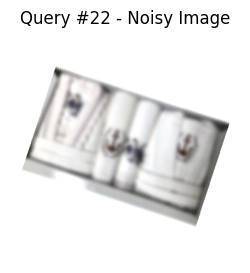


Query #97
Original text: مجسمه مدل عقاب در حال پرواز کد 1213 | دسته: تابلو و مجسمه
Noisy text: مجسمه دمل عقاب در حال پرواز کد 1213 | دسته: تالو  و مجسمه
Ground truth: tmpzbx
Category: تابلو و مجسمه

📝 Text-Only: Ground truth at rank 1
🖼️  Image-Only: Ground truth at rank 1
🔀 Multimodal: Ground truth at rank 1


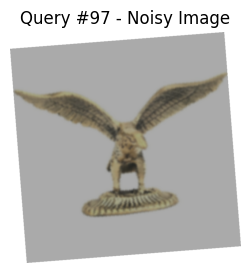


Query #46
Original text: ماشین لباسشویی دوقلو پاکشوما مدل PTN9604 ظرفیت ۹ کیلوگرم | برند: پاکشوما / Pakshoma | دسته: ماشین لب
Noisy text: ماشین لباسشیوی دوقلوپاکشوم امدل PPTN9604 ظرفیت ۹ کیلوگر م| برند: پاکشوما  Pakshomma | دسته: ماشین لل
Ground truth: ytkupk
Category: ماشین لباسشویی

📝 Text-Only: Ground truth at rank 3
🖼️  Image-Only: Ground truth at rank Not found
🔀 Multimodal: Ground truth at rank 4


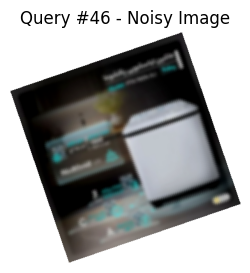

In [50]:
# Analyze sample queries
print("🔍 Sample Retrieval Examples")
print("=" * 70)

# Pick 3 random test samples
sample_indices = random.sample(range(len(test_dataset)), min(3, len(test_dataset)))

for idx in sample_indices:
    item = test_dataset[idx]
    
    print(f"\n{'='*70}")
    print(f"Query #{idx + 1}")
    print(f"{'='*70}")
    print(f"Original text: {item['original_text'][:100]}")
    print(f"Noisy text: {item['noisy_text'][:100]}")
    print(f"Ground truth: {item['product_id']}")
    print(f"Category: {item['metadata'].get('category_title', 'N/A')}")
    
    # Get retrievals
    text_ret = text_retrieval(item["noisy_text"], k=5)
    image_ret = image_retrieval(item["noisy_image"], k=5)
    multi_ret = multimodal_retrieval(item["noisy_text"], item["noisy_image"], k=5, alpha=best_alpha)
    
    # Check if ground truth in results
    text_rank = text_ret.index(item['product_id']) + 1 if item['product_id'] in text_ret else "Not found"
    image_rank = image_ret.index(item['product_id']) + 1 if item['product_id'] in image_ret else "Not found"
    multi_rank = multi_ret.index(item['product_id']) + 1 if item['product_id'] in multi_ret else "Not found"
    
    print(f"\n📝 Text-Only: Ground truth at rank {text_rank}")
    print(f"🖼️  Image-Only: Ground truth at rank {image_rank}")
    print(f"🔀 Multimodal: Ground truth at rank {multi_rank}")
    
    # Display noisy image
    plt.figure(figsize=(3, 3))
    plt.imshow(item["noisy_image"])
    plt.axis('off')
    plt.title(f"Query #{idx + 1} - Noisy Image")
    plt.show()

print("\n" + "=" * 70)

In [49]:
# Save best configuration
best_config = {
    "hyperparameters": {
        "alpha": best_alpha,
        "k": K_VALUE
    },
    "performance": {
        "text_only": {
            "MRR": float(text_results["MRR"]),
            "Precision@k": float(text_results["Precision@k"])
        },
        "image_only": {
            "MRR": float(image_results["MRR"]),
            "Precision@k": float(image_results["Precision@k"]),
            "Category_Hit_Rate@2-10": float(image_results.get("Category_Hit_Rate@2-10", 0.0))
        },
        "multimodal": {
            "MRR": float(multimodal_results["MRR"]),
            "Precision@k": float(multimodal_results["Precision@k"]),
            "Category_Hit_Rate@2-10": float(multimodal_results.get("Category_Hit_Rate@2-10", 0.0))
        }
    },
    "test_dataset_size": len(test_dataset),
    "optimization_trials": N_TRIALS,
    "optimization_objective": "Category_Hit_Rate@2-10",
    "random_seed": RANDOM_SEED
}

config_path = OUTPUTS_DIR / "best_rag_config.json"
with open(config_path, "w") as f:
    json.dump(best_config, f, indent=2)

print(f"\n💾 Best configuration saved to: {config_path}")


💾 Best configuration saved to: /home/roshan/Aria/mlops/outputs/best_rag_config.json
